In [1]:
"""
Taxi Data Preprocessing Notebook

This notebook performs data cleaning, feature engineering, and aggregation of NYC taxi data.
"""

'\nTaxi Data Preprocessing Notebook\n\nThis notebook performs data cleaning, feature engineering, and aggregation of NYC taxi data.\n'

# Data Preprocessing 

In [ ]:
import os
import sys
from collections import Counter
from functools import reduce
import numpy as np  
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.sql import SparkSession
from datetime import timedelta

## Read Taxi Data, Establish Raw Layer

In [3]:
# Create session
spark = (
    SparkSession.builder.appName("Taxi Preprocessing")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "America/New_York")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/08/30 14:09:11 WARN Utils: Your hostname, JamesNsPC, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/08/30 14:09:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/30 14:09:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/30 14:09:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


#### Look for inconsistencies and get the newest schema

In [4]:
# List of schema for each file
schema_map_list = []

# Read each parquet & store schema as dict
for file in os.listdir("../data/landing/taxi_data"):
    if file.endswith(".parquet"):
        file_path = f"../data/landing/taxi_data/{file}"
        sdf = spark.read.parquet(file_path)
        schema_dict = {f.name: f.dataType for f in sdf.schema.fields}
        # for col, dtype in schema_dict.items():
        # print(f"{col}: {dtype.simpleString()}")
        schema_map_list.append((file_path, schema_dict))

# Find most common schema
schema_only_list = [schema for _, schema in schema_map_list]
schema_counts = Counter([frozenset(s.items()) for s in schema_only_list])
most_common_schema_items = dict(dict(schema_counts.most_common(1)[0][0]))

print("Most Common Schema:")
for col, dtype in most_common_schema_items.items():
    print(f"{col}: {dtype}")


# Compare most recent to most common
recent_parquet_path = "../data/landing/taxi_data/2024-12.parquet"
sdf = spark.read.parquet(recent_parquet_path)
recent_schema_dict = {f.name: f.dataType for f in sdf.schema.fields}
# Check for mismatches in the most recent file
misnamed_cols = set(recent_schema_dict) - set(most_common_schema_items)
type_mismatches = {
    col: (
        most_common_schema_items[col].simpleString(),
        recent_schema_dict[col].simpleString(),
    )
    for col in recent_schema_dict
    if col in most_common_schema_items
    and recent_schema_dict[col] != most_common_schema_items[col]
}

print(f"There are {len(type_mismatches)} mismatches")


# No mismatches so far, so we can know the up to date schema is correct

"""
# Compare each file’s schema to the reference
for file_path, schema_dict in schema_map_list:
    misnamed_cols = set(schema_dict) - set(most_common_schema_items)
    type_mismatches = {
        col: (most_common_schema_items[col].simpleString(), schema_dict[col].simpleString())
        for col in schema_dict
        if col in most_common_schema_items and schema_dict[col] != most_common_schema_items[col]
    }

    
if misnamed_cols or type_mismatches:
    print(f"\nMismatches in {file_path}:")
    if misnamed_cols:
        print(f"Misnamed columns: {misnamed_cols} ")
    if type_mismatches:
        print(f"Type mismatches: {type_mismatches} ")"""

Most Common Schema:
payment_type: LongType()
tpep_pickup_datetime: TimestampNTZType()
mta_tax: DoubleType()
total_amount: DoubleType()
tip_amount: DoubleType()
VendorID: IntegerType()
fare_amount: DoubleType()
tpep_dropoff_datetime: TimestampNTZType()
DOLocationID: IntegerType()
store_and_fwd_flag: StringType()
improvement_surcharge: DoubleType()
tolls_amount: DoubleType()
congestion_surcharge: DoubleType()
extra: DoubleType()
PULocationID: IntegerType()
Airport_fee: DoubleType()
trip_distance: DoubleType()
RatecodeID: LongType()
passenger_count: LongType()
There are 0 mismatches


'\n# Compare each file’s schema to the reference\nfor file_path, schema_dict in schema_map_list:\n    misnamed_cols = set(schema_dict) - set(most_common_schema_items)\n    type_mismatches = {\n        col: (most_common_schema_items[col].simpleString(), schema_dict[col].simpleString())\n        for col in schema_dict\n        if col in most_common_schema_items and schema_dict[col] != most_common_schema_items[col]\n    }\n\n\nif misnamed_cols or type_mismatches:\n    print(f"\nMismatches in {file_path}:")\n    if misnamed_cols:\n        print(f"Misnamed columns: {misnamed_cols} ")\n    if type_mismatches:\n        print(f"Type mismatches: {type_mismatches} ")'

## 1. Convert each parquet to match newest (correct schema)

In [5]:
def process_sdf(sdf, file_name, schema):
    """
    Processes taxi sdf to handle inconsistent data types/naming.
    Saves the raw layer DataFrame as a parquet with consistent schema and naming.
    """

    PATH = f"../data/raw/taxi_data/{file_name}"

    # Lowercase all column names
    sdf = sdf.toDF(*[col.lower() for col in sdf.columns])

    consistent_col_casing = [
        F.col(col_name).alias(col_name.lower()) for col_name in sdf.columns
    ]
    sdf = sdf.select(*consistent_col_casing)

    # Cast types to correct schema
    for col, dtype in schema.items():
        col_lower = col.lower()
        if dtype == sdf.schema[col_lower].dataType:
            continue
        # Change column types to match the most common schema
        sdf = sdf.withColumn(col_lower, sdf[col_lower].cast(dtype))

    # Create new file for sdf (raw layer)
    sdf.write.parquet(PATH, mode="overwrite")

In [6]:
raw_dir = "../data/raw/taxi_data"
os.makedirs(raw_dir, exist_ok=True)

In [7]:
# Run process sdf to save raw data
for file in os.listdir("../data/landing/taxi_data"):
    if file.endswith(".parquet"):
        file_path = f"../data/landing/taxi_data/{file}"
        sdf = spark.read.parquet(file_path)
        process_sdf(sdf, file, recent_schema_dict)

## 2. Identify and handle missing values

In [8]:
# Reread the data
taxi_sdf = spark.read.option("recursiveFileLookup", "true").parquet(
    "../data/raw/taxi_data"
)
print(f"Rows in raw taxi_data: {taxi_sdf.count():,}")


Rows in raw taxi_data: 41,169,720


Get borough column 

In [9]:
# Map location ID's to borough and identify within borough trips

# Read lookup
taxi_zones = spark.read.csv(
    "../data/import_csvs/taxi_zones/taxi_zone_lookup.csv", header=True, inferSchema=True
)

# Join taxi_sdf with taxi_zones to get pickup and dropoff boroughs
taxi_sdf = taxi_sdf.join(
    taxi_zones.select(
        F.col("LocationID").alias("PULocationID"), F.col("Borough").alias("PUBorough")
    ),
    on="PULocationID",
    how="left",
).join(
    taxi_zones.select(
        F.col("LocationID").alias("DOLocationID"), F.col("Borough").alias("DOBorough")
    ),
    on="DOLocationID",
    how="left",
)

In [10]:
sys.path.append("../functions")
from processing import is_expected, report_null

In [11]:
report_null(taxi_sdf, "Taxi")


 Results for Taxi
Taxi, passenger_count: 4,091,232 missing values
Taxi, ratecodeid: 4,091,232 missing values
Taxi, store_and_fwd_flag: 4,091,232 missing values
Taxi, congestion_surcharge: 4,091,232 missing values
Taxi, airport_fee: 4,091,232 missing values
Taxi, PUBorough: 24,001 missing values
Taxi, DOBorough: 183,903 missing values
20664064


Number of missing values for most column are the same so they are likely from the same subset of trips. 

We will handle Borough later

Let's try identify what this subset is:

In [12]:
# Filter rows with any missing values
missing_sdf = taxi_sdf.filter(
    reduce(lambda a, b: a | b, [F.col(c).isNull() for c in taxi_sdf.columns])
)
# Randomly sample 10 rows
missing_sample = missing_sdf.orderBy(F.rand(seed=1462474)).limit(10)

# Show the sampled records
missing_sample.select(taxi_sdf.columns).show(truncate=False)


+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+---------+
|dolocationid|pulocationid|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|PUBorough|DOBorough|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------+---------+
|263         |234         |2       |2024-04-14 21:33:24 |2024-04-14 21:51:33  |NULL           |3.22         |NULL      |NULL   

These all look to be trips with payment type 0

In [13]:
# Show only records with payment type = 0

not_payment_0 = missing_sdf.filter(F.col("payment_type") == 1)

# Print num rows in the full sdf with payment type = 1
not_payment_0.count()

# Print num rows in the full sdf with payment type = 0
taxi_sdf.filter(F.col("payment_type") == 0).count()


4091232

This is the category for taxi services reserved online through the app.
Removing these values would bias my dataset to street hails and other payment types.

Passenger count is the most likely to impact my predictions so for passenger count I will impute them with the most common value.
As I am not analysing passenger count specifically it is better to keep the records and just use imputation for modelling.


Other attributes are less related to demand and revenue or can be explained by other attributes so I will remove them.

In [14]:
# Impute missing values for the 3 columns we want to keep:
#  passenger_count, congestion_surcharge, airport_fee

# 1. Impute passenger_count with the mode (most common value)
most_common_passenger_count = (
    taxi_sdf.groupBy("passenger_count")
    .agg(F.count("*").alias("count"))
    .orderBy(F.desc("count"))
    .first()["passenger_count"]
)
taxi_sdf = taxi_sdf.withColumn(
    "passenger_count",
    F.when(F.col("passenger_count").isNull(), most_common_passenger_count).otherwise(
        F.col("passenger_count")
    ),
)

# 2. Drop other columns as they would affect aggregation
taxi_sdf = taxi_sdf.drop(
    "ratecodeid", "store_and_fwd_flag", "congestion_surcharge", "airport_fee"
)

In [15]:
# Show a sample of records with PUBorough == "Unknown" BEFORE aggregation
unknown_borough = taxi_sdf.filter(
    (F.col("PUBorough") == "Unknown") | (F.col("DOBorough") == "Unknown")
)
unknown_borough.show(20, truncate=False)
print(f"Total records with Borough == 'Unknown': {unknown_borough.count()}")

+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+---------+
|dolocationid|pulocationid|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|PUBorough|DOBorough|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+---------+
|264         |264         |2       |2024-07-01 00:25:44 |2024-07-01 00:25:45  |1              |0.0          |1           |13.0       |0.0  |0.5    |0.0       |0.0         |1.0                  |14.5        |Unknown  |Unknown  |
|262         |264         |1       |2024-07-01 00:00:17 |2024-07-01 00:15:10  |2        

In [16]:
# We only want records we know are in NYC and can identify the location
# So drop all with "Unknown" borough
taxi_sdf = taxi_sdf.filter(
    (F.col("PUBorough") != "Unknown") & (F.col("DOBorough") != "Unknown")
)

# Also remove null boroughs
taxi_sdf = taxi_sdf.filter((F.col("PUBorough").isNotNull()) & (F.col("DOBorough").isNotNull()))

In [17]:
taxi_sdf.count()

40744060

## 3. Handle Range Checking


Only checking the most vital fields as it will take too long to check every record

In [18]:
# Import our expected range dict
sys.path.append("../data/processing_info")
from expected_range import expected_ranges


In [19]:
results, combined_cond = is_expected(taxi_sdf, expected_ranges)

Column 'trip_distance': 1,222,647 Invalid values found.
Column 'PULocationID': 0 Invalid values found.
Column 'DOLocationID': 0 Invalid values found.
Column 'fare_amount': 722,318 Invalid values found.
Column 'total_amount': 600,631 Invalid values found.


We will filter other rows if necessary however these are the main ones required for analysis

Seeing all of these columns are vital to analysis and imputation is not possible (would create inaccurate data) we will drop each of these out of bounds records.

In [20]:
# Apply the column condition to each row and filter
taxi_sdf = taxi_sdf.filter(~combined_cond)

In [21]:
sorted_trips = taxi_sdf.orderBy(F.col("trip_distance").asc())
sorted_trips.show(10)

+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+---------+
|dolocationid|pulocationid|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|PUBorough|DOBorough|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------+---------+
|         262|         263|       1| 2024-08-24 19:00:36|  2024-08-24 19:03:31|              1|          0.3|           2|        4.4|  2.5|    0.5|       0.0|         0.0|                  1.0|         8.4|Manhattan|Manhattan|
|         161|         161|       1| 2024-06-10 20:28:32|  2024-06-10 20:33:41|         

In [22]:
taxi_sdf.count()


38912304

Lastly we filter to use only data from year (2024) separate to our combined cond method to avoid timezone issues

In [23]:
# Filter taxi_sdf to only include records where BOTH pickup and dropoff are in 2024
taxi_sdf = taxi_sdf.filter(
    (F.year("tpep_pickup_datetime") == 2024) &
    (F.year("tpep_dropoff_datetime") == 2024)
)

In [24]:
taxi_sdf.count()

38911708

## 4. Remove Duplicates

In [25]:
# Find and remove duplicates in taxi_sdf
taxi_sdf = taxi_sdf.dropDuplicates()

In [26]:
taxi_sdf.count()

38911706

## 5. Outlier Analysis

Here we will flag outliers so we can remove them from plots/models later if necessary

#### First we will create our trip duration feauture as we can use it to detect outliers

In [27]:
# Trip duration (minutes)
taxi_sdf = taxi_sdf.withColumn(
    "trip_duration",
    (
        F.to_unix_timestamp("tpep_dropoff_datetime")
        - F.to_unix_timestamp("tpep_pickup_datetime")
    )
    / 60,
)

# We will remove all trips with a duration of 0 minutes as these are not useful for our analysis
taxi_sdf = taxi_sdf.filter(F.col("trip_duration") > 0)


Inspect data

In [28]:
# Select columns to check for outliers (our columns of interest later)
cols_to_check = [
    "trip_distance",
    "total_amount",
    "fare_amount",
    "trip_duration",
]

# Convert a sample to pandas for plotting 
taxi_sample_pd = (
    taxi_sdf.select(cols_to_check).sample(fraction=0.01, seed=1462474).toPandas()
)

# Log-transform the data (add a small constant to avoid log(0))
log_taxi_sample_pd = taxi_sample_pd.copy()
for col in cols_to_check:
    log_taxi_sample_pd[col] = np.log(taxi_sample_pd[col][taxi_sample_pd[col] > 0])

In [29]:
# Calculate percentiles for each column using the full sdf
percentiles = {}
wider_percentiles = {}
for col in cols_to_check:
    lower, upper = taxi_sdf.approxQuantile(col, [0.001, 0.999], 0.0001)
    wider_lower, wider_upper = taxi_sdf.approxQuantile(col, [0.005, 0.995], 0.0001)
    percentiles[col] = (lower, upper)
    wider_percentiles[col] = (wider_lower, wider_upper)

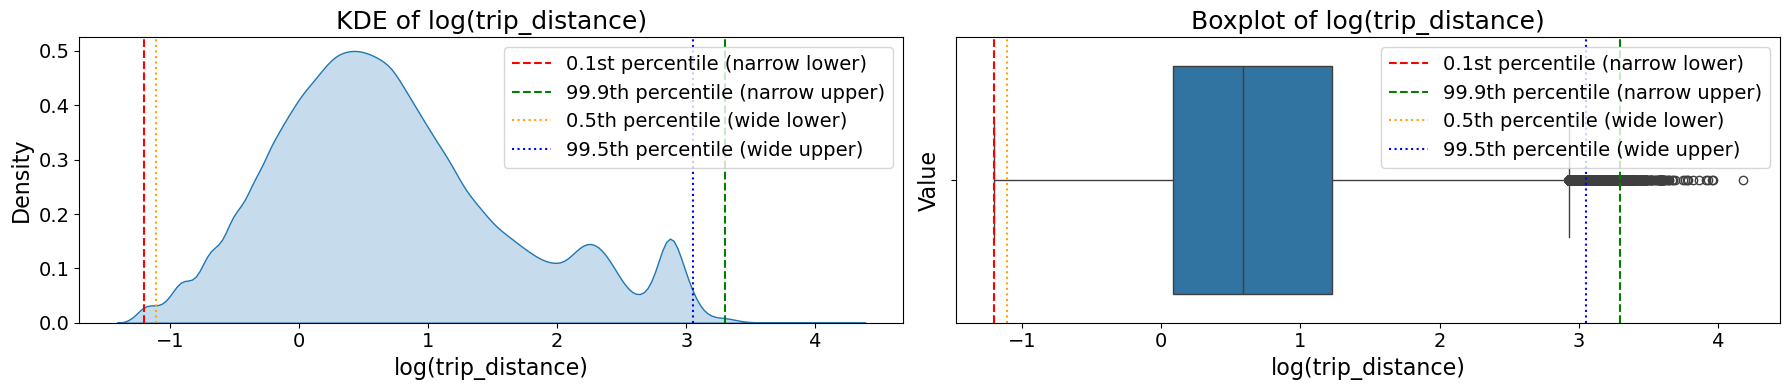

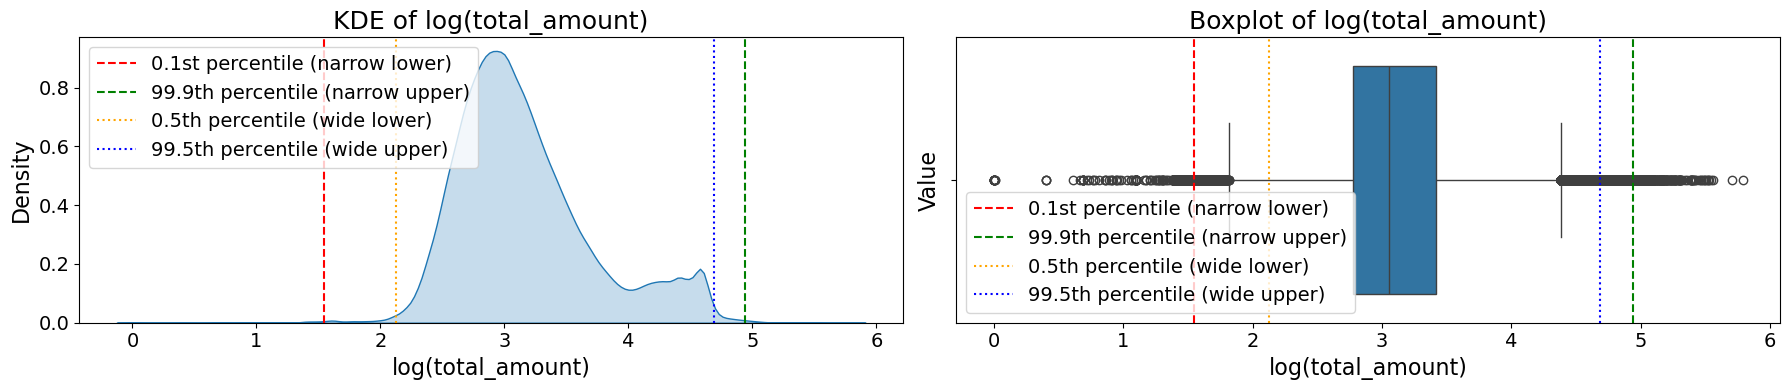

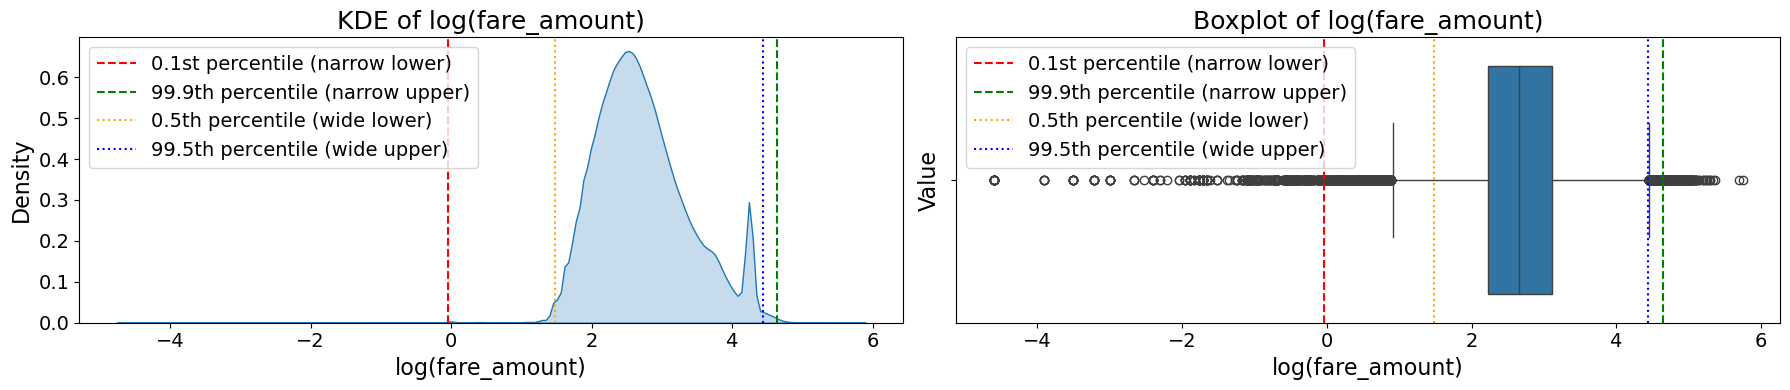

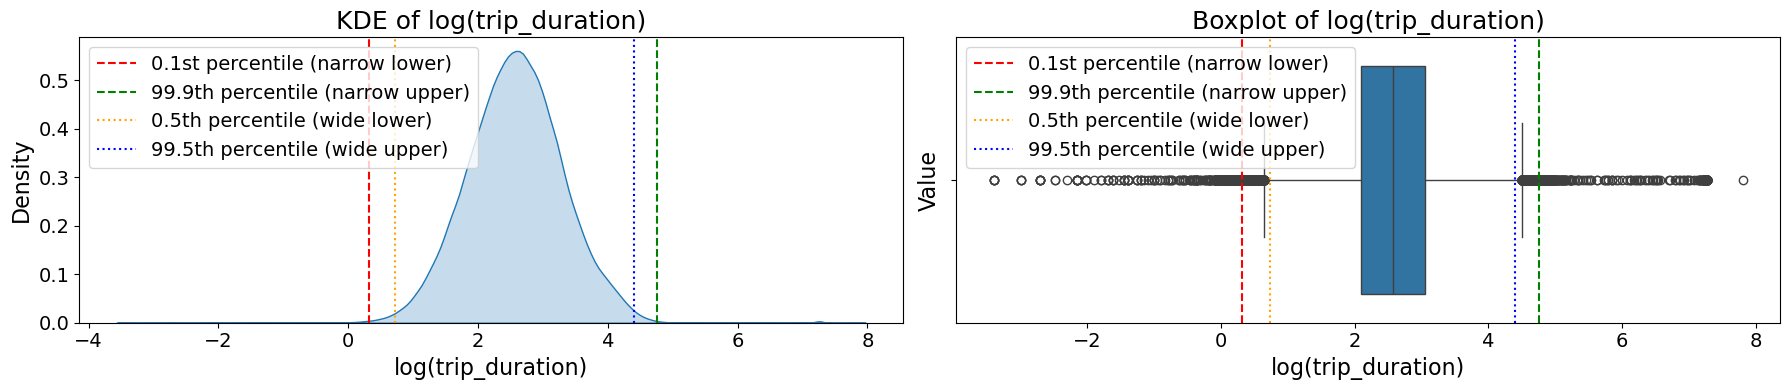

25/08/30 22:58:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1427801 ms exceeds timeout 120000 ms
25/08/30 22:58:34 WARN SparkContext: Killing executors is not supported by current scheduler.
25/08/30 22:58:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:342)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [30]:
# Plot log-transformed KDE plots, and boxplots with percentile lines (percentiles shown on log scale)
for col in cols_to_check:
    data = log_taxi_sample_pd[col].dropna()
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))
    # KDE plot
    sns.kdeplot(data, ax=axes[0], fill=True)
    axes[0].axvline(np.log(percentiles[col][0]), color="red", linestyle="--", label="0.1st percentile (narrow lower)")
    axes[0].axvline(np.log(percentiles[col][1]), color="green", linestyle="--", label="99.9th percentile (narrow upper)")
    axes[0].axvline(np.log(wider_percentiles[col][0]), color="orange", linestyle=":", label="0.5th percentile (wide lower)")
    axes[0].axvline(np.log(wider_percentiles[col][1]), color="blue", linestyle=":", label="99.5th percentile (wide upper)")
    axes[0].set_title(f"KDE of log({col})", fontsize=18)
    axes[0].set_xlabel(f"log({col})", fontsize=16)
    axes[0].set_ylabel("Density", fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[0].legend(fontsize=14)
    # Boxplot
    sns.boxplot(x=data, ax=axes[1])
    axes[1].axvline(np.log(percentiles[col][0]), color="red", linestyle="--", label="0.1st percentile (narrow lower)")
    axes[1].axvline(np.log(percentiles[col][1]), color="green", linestyle="--", label="99.9th percentile (narrow upper)")
    axes[1].axvline(np.log(wider_percentiles[col][0]), color="orange", linestyle=":", label="0.5th percentile (wide lower)")
    axes[1].axvline(np.log(wider_percentiles[col][1]), color="blue", linestyle=":", label="99.5th percentile (wide upper)")
    axes[1].set_title(f"Boxplot of log({col})", fontsize=18)
    axes[1].set_xlabel(f"log({col})", fontsize=16)
    axes[1].set_ylabel("Value", fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=14)
    axes[1].legend(fontsize=14)
    plt.tight_layout()


Most attributes in this sample are right skewed, so we will flag extreme outliers to reduce bias.
In our aggregated sdf we will remove outliers before aggregating to reduce their impact on the results.

We perform outlier analysis on the full dataset as below:

In [31]:
# Use previously computed percentiles for outlier removal

# percentiles: 0.1st and 99.9th (narrow)
# wider_percentiles: 0.5th and 99.5th (wide)

# Remove outliers in each column as needed
# Use the wider interval for duration and amounts, narrower for distance (from inspection)

# Creates the conditions to check for outliers
outlier_conds = []
for col in cols_to_check:
    if col == "trip_distance":
        lower, upper = percentiles[col]  # 0.1st and 99.9th
        print(f"{col}: flag if < {lower:.2f} or > {upper:.2f} (narrow)")
    else:
        lower, upper = wider_percentiles[col]  # 0.5th and 99.5th
        print(f"{col}: flag if < {lower:.2f} or > {upper:.2f} (wide)")
    outlier_cond = (F.col(col) < lower) | (F.col(col) > upper)
    outlier_conds.append(outlier_cond)
    # Count and print the number of records classed as outliers for removal
    outlier_count = taxi_sdf.filter(outlier_cond).count()
    print(f"Outliers flagged in {col}: {outlier_count}")


trip_distance: flag if < 0.30 or > 27.08 (narrow)


Outliers flagged in trip_distance: 39804
total_amount: flag if < 8.40 or > 108.60 (wide)


Outliers flagged in total_amount: 392040
fare_amount: flag if < 4.40 or > 84.90 (wide)


Outliers flagged in fare_amount: 345422
trip_duration: flag if < 2.07 or > 81.33 (wide)


Outliers flagged in trip_duration: 391307


In [32]:
# Combine all outlier conditions
any_outlier = reduce(lambda a, b: a | b, outlier_conds)

# Filter out any row that has an outlier in any checked column
taxi_sdf = taxi_sdf.filter(~any_outlier)

In [33]:
taxi_sdf.count()

25/08/28 00:51:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


38095566

## 6. Feature Engineering 

#### Temporal Features

First we will make temporal features that are more interpretable than timestamp

In [35]:
# Month
taxi_sdf = taxi_sdf.withColumn("month", F.month(F.col("tpep_pickup_datetime")))

In [36]:
# Seasons
taxi_sdf = taxi_sdf.withColumn(
    "season",
    F.when(F.col("month").isin(12, 1, 2), "Winter")
    .when(F.col("month").isin(3, 4, 5), "Spring")
    .when(F.col("month").isin(6, 7, 8), "Summer")
    .when(F.col("month").isin(9, 10, 11), "Fall"),
)


In [37]:
# Day of the week
taxi_sdf = taxi_sdf.withColumn(
    "day_of_week", F.dayofweek(F.col("tpep_pickup_datetime"))
)

# Is weekend
taxi_sdf = taxi_sdf.withColumn(
    "is_weekend", F.when(F.col("day_of_week").isin(6, 7), True).otherwise(False)
)

In [38]:
# Hour of the day
# Returns integer: 0–23
taxi_sdf = taxi_sdf.withColumn("pickup_hour", F.hour(F.col("tpep_pickup_datetime")))

In [39]:
# Quarter
taxi_sdf = taxi_sdf.withColumn("quarter", F.quarter(F.col("tpep_pickup_datetime")))


# Week of the year
taxi_sdf = taxi_sdf.withColumn(
    "week_of_year", F.weekofyear(F.col("tpep_pickup_datetime"))
)


In [40]:
# Show data to see if this worked
taxi_sdf.select(
    "month",
    "season",
    "day_of_week",
    "pickup_hour",
    "quarter",
    "week_of_year",
    "trip_duration",
).show(10)

+-----+------+-----------+-----------+-------+------------+------------------+
|month|season|day_of_week|pickup_hour|quarter|week_of_year|     trip_duration|
+-----+------+-----------+-----------+-------+------------+------------------+
|    7|Summer|          2|          0|      3|          27| 9.366666666666667|
|    7|Summer|          2|          0|      3|          27| 36.11666666666667|
|    7|Summer|          2|          0|      3|          27|23.783333333333335|
|    7|Summer|          2|          0|      3|          27|             31.05|
|    7|Summer|          2|          0|      3|          27|10.266666666666667|
|    7|Summer|          2|          0|      3|          27|              22.8|
|    7|Summer|          2|          0|      3|          27|30.383333333333333|
|    7|Summer|          2|          0|      3|          27|20.483333333333334|
|    7|Summer|          2|          0|      3|          27| 40.28333333333333|
|    7|Summer|          2|          0|      3|      

#### Spatial Features

In [41]:
# Add a flag for within-borough trips
taxi_sdf = taxi_sdf.withColumn(
    "within_borough_trip",
    F.when(F.col("PUBorough") == F.col("DOBorough"), 1).otherwise(0),
)

## 7. Aggregation

First we must ensure that we have a complete dataset with all possible zone combinations for creating lag features. This will be done by creating records with 0's for combinations that don't exist within our dataset. 


In [42]:
# Get all unique pickup zones (PULocationID) present in your data only
zone_ids = [row['PULocationID'] for row in taxi_sdf.select('PULocationID').distinct().collect()]

# Get full range of hourly timestamps in your data
min_hour = taxi_sdf.agg(F.min(F.col("tpep_pickup_datetime"))).first()[0]
max_hour = taxi_sdf.agg(F.max(F.col("tpep_pickup_datetime"))).first()[0]


# Generate all hourly timestamps between min and max
all_hours = []
current = min_hour.replace(minute=0, second=0, microsecond=0)
while current <= max_hour:
    all_hours.append(current)
    current += timedelta(hours=1)

# Create sdfs for all zones and all hours
zone_df = spark.createDataFrame([(z,) for z in zone_ids], ["PULocationID"])
hour_df = spark.createDataFrame([(h,) for h in all_hours], ["pickup_datetime_hour"])

# Cross join to get all (zone, hour) combinations
full_grid = zone_df.crossJoin(hour_df)


In [43]:
# Create a column truncated to the hour for grouping
taxi_sdf = taxi_sdf.withColumn(
    "pickup_datetime_hour", F.date_trunc("hour", F.col("tpep_pickup_datetime"))
)

# Aggregate taxi data (group by PULocationID, pickup_datetime_hour)
agg_sdf = taxi_sdf.groupBy("PULocationID", "pickup_datetime_hour").agg(
    F.count("*").alias("trips"),
    F.sum("fare_amount").alias("total_fare_amount"),
    F.sum("total_amount").alias("total_amount_sum"),
    F.expr("percentile_approx(total_amount, 0.5)").alias("median_total_amount"),
    F.mean("total_amount").alias("mean_total_amount"),  
    F.expr("percentile_approx(trip_distance, 0.5)").alias("median_trip_distance"),
    F.mean("trip_distance").alias("mean_trip_distance"),  
    F.expr("percentile_approx(trip_duration, 0.5)").alias("median_trip_duration"),
    F.mean("trip_duration").alias("mean_trip_duration"), 
    F.mean("passenger_count").alias("avg_passenger_count"),
    F.sum("tip_amount").alias("total_tip_amount"),
    F.sum("tolls_amount").alias("total_tolls_amount"),
    F.sum("extra").alias("total_extra"),
    F.sum("improvement_surcharge").alias("total_improvement_surcharge"),
    F.sum("mta_tax").alias("total_mta_tax"),
    (F.sum("within_borough_trip") / F.count("*")).alias("pct_within_borough_trip"),
    F.first("is_weekend").alias("is_weekend"),
    F.first("season").alias("season"),
    F.first("quarter").alias("quarter"),
)


# Assume its extremely unlikely that outlier removal removed a full aggregated row 
# as our data is not extremely noisy this is fine
# Left join full_grid with agg_sdf to fill missing (zone, hour) with zeroes
agg_sdf = full_grid.join(agg_sdf, ["PULocationID", "pickup_datetime_hour"], "left")


In [44]:
# Fill nulls in numeric columns with 0 
agg_sdf = agg_sdf.fillna({
    "trips": 0,
    "total_fare_amount": 0,
    "total_amount_sum": 0,
    "median_total_amount": 0,
    "mean_total_amount": 0,
    "median_trip_distance": 0,
    "mean_trip_distance": 0,
    "median_trip_duration": 0,
    "mean_trip_duration": 0,
    "avg_passenger_count": 0,
    "total_tip_amount": 0,
    "total_tolls_amount": 0,
    "total_extra": 0,
    "total_improvement_surcharge": 0,
    "total_mta_tax": 0,
    "pct_within_borough_trip": 0,
})



#### Further feature engineering

In [45]:
# Create temporal features
agg_sdf = (
    agg_sdf
    .withColumn("pickup_hour", F.hour("pickup_datetime_hour"))
    .withColumn("week_of_year", F.weekofyear("pickup_datetime_hour"))
    .withColumn("month", F.month("pickup_datetime_hour"))
    .withColumn("day_of_week", F.dayofweek("pickup_datetime_hour"))
    .withColumn("is_weekend", F.when(F.col("day_of_week").isin(6, 7), True).otherwise(False))
    .withColumn(
        "season",
        F.when(F.col("month").isin(12, 1, 2), "Winter")
         .when(F.col("month").isin(3, 4, 5), "Spring")
         .when(F.col("month").isin(6, 7, 8), "Summer")
         .when(F.col("month").isin(9, 10, 11), "Fall")
    )
    .withColumn("quarter", F.quarter("pickup_datetime_hour"))
)

# Join with taxi_zones to get PUBorough
agg_sdf = agg_sdf.join(
    taxi_zones.select(F.col("LocationID").alias("PULocationID"), "Borough"),
    on="PULocationID",
    how="left"
).withColumnRenamed("Borough", "PUBorough")


In [46]:
# Check our features created as intended by inspection
agg_sdf.show(10, truncate=False)


+------------+--------------------+-----+-----------------+----------------+-------------------+-----------------+--------------------+------------------+--------------------+------------------+-------------------+----------------+------------------+-----------+---------------------------+-------------+-----------------------+----------+------+-------+-----------+------------+-----+-----------+---------+
|PULocationID|pickup_datetime_hour|trips|total_fare_amount|total_amount_sum|median_total_amount|mean_total_amount|median_trip_distance|mean_trip_distance|median_trip_duration|mean_trip_duration|avg_passenger_count|total_tip_amount|total_tolls_amount|total_extra|total_improvement_surcharge|total_mta_tax|pct_within_borough_trip|is_weekend|season|quarter|pickup_hour|week_of_year|month|day_of_week|PUBorough|
+------------+--------------------+-----+-----------------+----------------+-------------------+-----------------+--------------------+------------------+--------------------+---------

In [47]:
agg_sdf.count()

2292624

#### Save Curated Data 

Aggregated

In [48]:
# Create aggregated data folder
os.makedirs("../data/curated/taxi_data/aggregated", exist_ok=True)
# Write the aggregated DataFrame to parquet
agg_sdf.write.mode("overwrite").parquet("../data/curated/taxi_data/aggregated")

#### End spark session

In [49]:
spark.stop()